<a href="https://colab.research.google.com/github/michuschenk/TF2-Course/blob/main/CapstoneProject_TF2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy.io import loadmat

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [ ]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

In [3]:
# Load the dataset from your Drive folder
drive_path = '/content/gdrive/My Drive/'
data_path = drive_path + 'CapstoneProject_GettingStartedWithTF2/'

train = loadmat(data_path + 'train_32x32.mat')
test = loadmat(data_path + 'test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

**Define some functions to preprocess and plot the data**

In [7]:
def prepare_rawdata(data_dict):
    ''' Extract data and labels from data_dict, normalize image data to between
    0 and 1 and permute axes, such that [n_samples, dimx, dimy, channels]
    instead of [dimx, dimy, channels, nsamples]. '''
    data_x = data_dict['X'] / 255.
    data_x = np.transpose(data_x, (3, 0, 1, 2))
    data_y = np.array(data_dict['y']).flatten()
    # Note that the label for digit '0' is 10. Change that to 0 here.
    data_y[data_y == 10] = 0

    return data_x, data_y

In [17]:
def convert_to_grayscale(data_x):
    ''' Average over the color channel (axis 3), given that the dimensions of
    data_x are  [n_samples, dimx, dimy, n_channels] '''
    return np.mean(data_x, axis=3, keepdims=True)

In [14]:
def plot_random_samples(data_x, data_y, nx=4, ny=4):
    ''' Choose nx*ny samples randomly from the dataset and plot them
    along with the correct labels. data_x has dimensions
    [n_samples, dimx, dimy, nchannels]'''
    fig, axs = plt.subplots(ny, nx, figsize=(nx*2, ny*2))
    axs = axs.flatten()
    
    # Select random samples
    img_idcs = np.random.choice(
        np.arange(data_x.shape[0]), size=nx*ny, replace=False)

    # Plot selected samples with label in axis title
    for i, img_idx in enumerate(img_idcs):
        if data_x.shape[3] == 1:
            # Greyscale
            axs[i].imshow(data_x[img_idx, :, :, 0],
                          cmap='gray', vmin=0, vmax=1)
        else:
            # RGB
            axs[i].imshow(data_x[img_idx, :, :, :],
                          vmin=0, vmax=1)
        axs[i].set_title(f'Label: {data_y[img_idx]}')
        axs[i].axis("off")

In [15]:
# 1) Extract train and test data (x, y), normalize images
# and permute axes
train_x, train_y = prepare_rawdata(train)
test_x, test_y = prepare_rawdata(test)

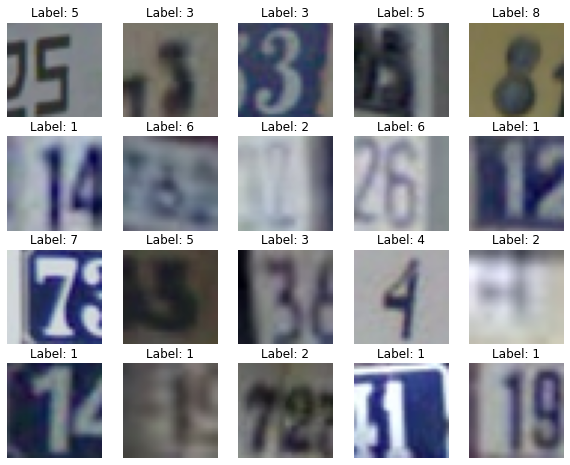

In [16]:
# 2) Plot random sample of rgb images
plot_random_samples(train_x, train_y, nx=5, ny=4)

In [18]:
# 3) Convert train and test images to grayscale (keeping all dimensions)
train_x = convert_to_grayscale(train_x)
test_x = convert_to_grayscale(test_x)

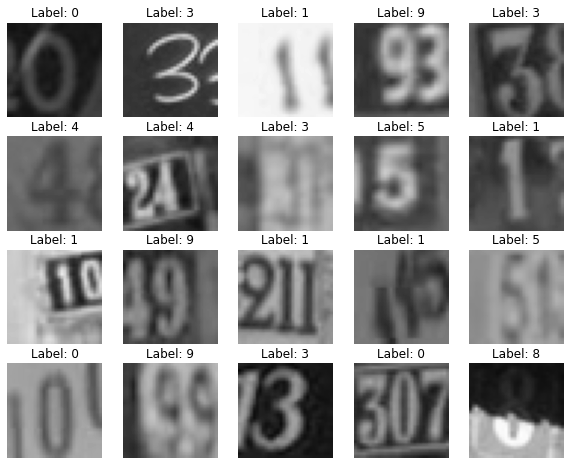

In [19]:
# 4) Plot random sample of greyscale images
plot_random_samples(train_x, train_y, nx=5, ny=4)

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

**Define some generic functions also used for the CNN below**

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [24]:
def compile_model(model):
    ''' Function compiles model with fixed parameters. '''
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

In [25]:
def train_model(model, train_x, train_y, callbacks):
    ''' Function to train model with fixed parameters. Returns history. '''
    return model.fit(train_x, train_y, epochs=30,
                     batch_size=128, validation_split=0.15,
                     callbacks=callbacks,
                     verbose=2)

In [26]:
def plot_loss_and_accuracy(df_history):
    ''' Creates two plots: one for train and validation loss; and one
    for train and validation accuracy. '''

    # Loss
    loss_plot = df_history.plot(y=['loss', 'val_loss'],
                                label=['training', 'validation'],
                                title='Loss')
    loss_plot.set(xlabel='epoch', ylabel='loss')

    # Accuracy
    accuracy_plot = df_history.plot(y=['accuracy', 'val_accuracy'],
                                    label=['training', 'validation'],
                                    title='Accuracy')
    accuracy_plot.set(xlabel='epoch', ylabel='accuracy')

In [27]:
def evaluate_test_performance(model, test_x, test_y):
    ''' Evaluates the loss and accuracy metrics on the held-out test set. '''
    test_loss, test_acc = model.evaluate(test_x, test_y, verbose=0)
    print('TEST SET PERFORMANCE')
    print(f'Loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')

**Get MLP model, train, and evaluate**

In [28]:
def get_new_mlp_model(input_shape, lw=1e-4):
    ''' Generate and return simple MLP model '''
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(256, activation='relu', kernel_regularizer=l2(lw)),
        Dense(128, activation='relu', kernel_regularizer=l2(lw)),
        Dense(64, activation='relu', kernel_regularizer=l2(lw)),
        Dense(10, activation='softmax')
    ], name='MLP')

    return model

In [29]:
# 1) Get new MLP model and print summary
mlp_model = get_new_mlp_model(train_x.shape[1:])
print(mlp_model.summary())

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 304,202
Trainable params: 304,202
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
# 2) Define callbacks
early_stopping = EarlyStopping(patience=5)

checkpoint_path = 'mlp_checkpoints/best_weights'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss',
                             save_best_only=True, save_weights_only=True)
mlp_callbacks = [early_stopping, checkpoint]

In [31]:
# 3) Compile and train model
compile_model(mlp_model)
mlp_history = train_model(mlp_model, train_x, train_y, mlp_callbacks)

Epoch 1/30
487/487 - 2s - loss: 2.2065 - accuracy: 0.2176 - val_loss: 1.9131 - val_accuracy: 0.3291
Epoch 2/30
487/487 - 2s - loss: 1.5963 - accuracy: 0.4668 - val_loss: 1.3682 - val_accuracy: 0.5675
Epoch 3/30
487/487 - 2s - loss: 1.2872 - accuracy: 0.5948 - val_loss: 1.2508 - val_accuracy: 0.5949
Epoch 4/30
487/487 - 2s - loss: 1.1602 - accuracy: 0.6431 - val_loss: 1.2123 - val_accuracy: 0.6146
Epoch 5/30
487/487 - 2s - loss: 1.0951 - accuracy: 0.6648 - val_loss: 1.0924 - val_accuracy: 0.6643
Epoch 6/30
487/487 - 2s - loss: 1.0398 - accuracy: 0.6841 - val_loss: 1.0369 - val_accuracy: 0.6783
Epoch 7/30
487/487 - 2s - loss: 0.9919 - accuracy: 0.7007 - val_loss: 0.9789 - val_accuracy: 0.7031
Epoch 8/30
487/487 - 2s - loss: 0.9582 - accuracy: 0.7127 - val_loss: 1.0188 - val_accuracy: 0.6942
Epoch 9/30
487/487 - 2s - loss: 0.9257 - accuracy: 0.7235 - val_loss: 0.9380 - val_accuracy: 0.7121
Epoch 10/30
487/487 - 2s - loss: 0.8947 - accuracy: 0.7350 - val_loss: 0.9392 - val_accuracy: 0.7135

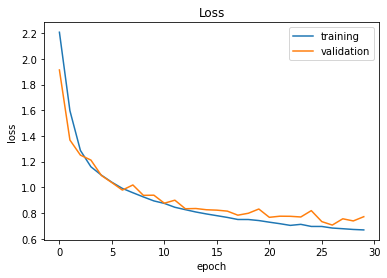

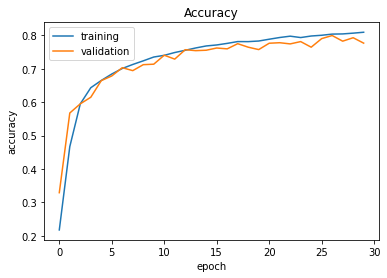

In [32]:
# 4) Display training and validation loss
df_mlp = pd.DataFrame(mlp_history.history)
plot_loss_and_accuracy(df_mlp)

In [33]:
# 5) Compute loss and accuracy on the test set
evaluate_test_performance(mlp_model, test_x, test_y)

TEST SET PERFORMANCE
Loss: 0.8607, accuracy: 0.7605


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [34]:
# All the other imports have been made above already
from tensorflow.keras.layers import (
    Conv2D, MaxPool2D, BatchNormalization, Dropout)

In [35]:
def get_new_cnn_model(input_shape, dropout_rate=0.3):
    ''' Generate and return simple CNN model '''
    model = Sequential([
        Conv2D(16, kernel_size=3, padding='SAME', activation='relu',
               input_shape=input_shape),
        BatchNormalization(),
        MaxPool2D(pool_size=2),
        Dropout(rate=dropout_rate),
        Conv2D(32, kernel_size=3, padding='SAME', activation='relu'),
        BatchNormalization(),
        MaxPool2D(pool_size=2),
        Dropout(rate=dropout_rate),
        Conv2D(64, kernel_size=3, padding='SAME', activation='relu'),
        BatchNormalization(),
        MaxPool2D(pool_size=2),
        Dropout(rate=dropout_rate),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(10, activation='softmax')
    ], name='CNN')

    return model

In [36]:
# 1) Get new CNN model and print summary
cnn_model = get_new_cnn_model(train_x.shape[1:])
print(cnn_model.summary())

# Verified that CNN uses fewer trainable params. than the MLP
# (91,530 vs. 304,202, resp., see above)

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0       

In [37]:
# 2) Define callbacks
early_stopping = EarlyStopping(patience=5)

checkpoint_path = 'cnn_checkpoints/best_weights'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss',
                             save_best_only=True, save_weights_only=True)

cnn_callbacks = [early_stopping, checkpoint]

In [38]:
# 3) Compile and train model
compile_model(cnn_model)
cnn_history = train_model(cnn_model, train_x, train_y, cnn_callbacks)

Epoch 1/30
487/487 - 5s - loss: 1.5077 - accuracy: 0.4770 - val_loss: 1.0937 - val_accuracy: 0.6501
Epoch 2/30
487/487 - 4s - loss: 0.6762 - accuracy: 0.7852 - val_loss: 0.5212 - val_accuracy: 0.8395
Epoch 3/30
487/487 - 4s - loss: 0.5548 - accuracy: 0.8238 - val_loss: 0.4104 - val_accuracy: 0.8750
Epoch 4/30
487/487 - 5s - loss: 0.4975 - accuracy: 0.8443 - val_loss: 0.4124 - val_accuracy: 0.8741
Epoch 5/30
487/487 - 5s - loss: 0.4574 - accuracy: 0.8571 - val_loss: 0.3490 - val_accuracy: 0.8965
Epoch 6/30
487/487 - 5s - loss: 0.4321 - accuracy: 0.8640 - val_loss: 0.3430 - val_accuracy: 0.8977
Epoch 7/30
487/487 - 4s - loss: 0.4153 - accuracy: 0.8707 - val_loss: 0.3277 - val_accuracy: 0.9001
Epoch 8/30
487/487 - 4s - loss: 0.3978 - accuracy: 0.8754 - val_loss: 0.3165 - val_accuracy: 0.9063
Epoch 9/30
487/487 - 4s - loss: 0.3853 - accuracy: 0.8800 - val_loss: 0.3260 - val_accuracy: 0.9034
Epoch 10/30
487/487 - 4s - loss: 0.3744 - accuracy: 0.8821 - val_loss: 0.3087 - val_accuracy: 0.9056

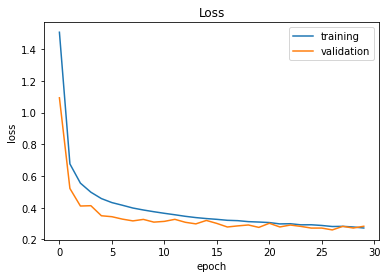

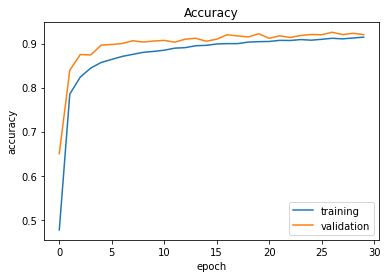

In [39]:
# 4) Display training and validation loss
df_cnn = pd.DataFrame(cnn_history.history)
plot_loss_and_accuracy(df_cnn)

In [40]:
# 5) Compute loss and accuracy on the test set
evaluate_test_performance(cnn_model, test_x, test_y)

TEST SET PERFORMANCE
Loss: 0.2955, accuracy: 0.9147


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [43]:
# Load MLP
mlp_model = get_new_mlp_model(train_x.shape[1:])
compile_model(mlp_model)
mlp_model.load_weights('mlp_checkpoints/best_weights')

print('MLP evaluation (cross-check):')
mlp_loss, mlp_acc = mlp_model.evaluate(test_x, test_y, verbose=2)

# Load CNN
cnn_model = get_new_cnn_model(train_x.shape[1:])
compile_model(cnn_model)
cnn_model.load_weights('cnn_checkpoints/best_weights')

print('\nCNN evaluation (cross-check):')
cnn_loss, cnn_acc = cnn_model.evaluate(test_x, test_y, verbose=2)

MLP evaluation (cross-check):
814/814 - 2s - loss: 0.8142 - accuracy: 0.7783

CNN evaluation (cross-check):
814/814 - 2s - loss: 0.2846 - accuracy: 0.9187


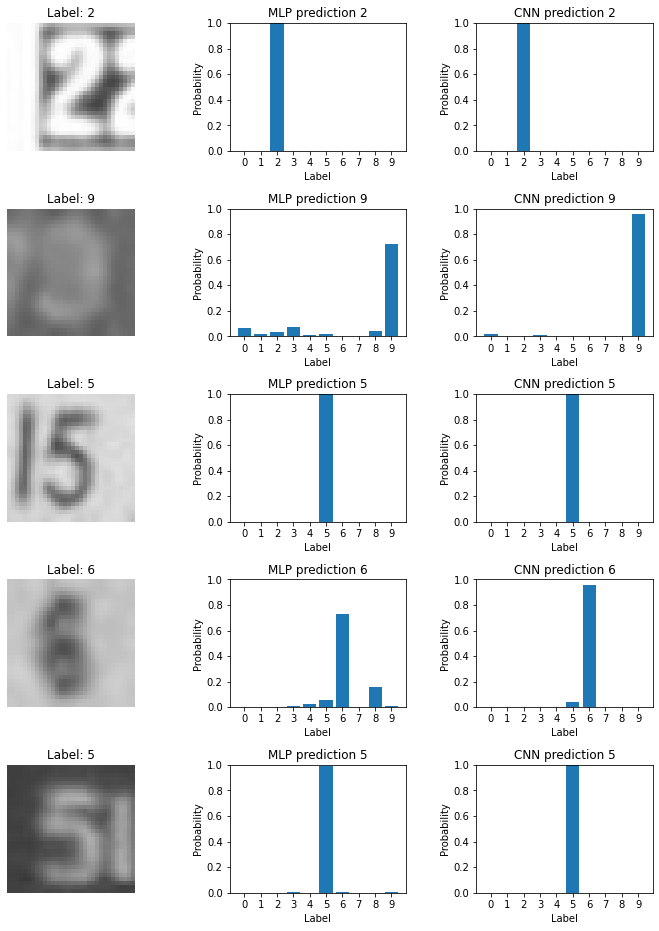

In [80]:
# Randomly select 5 images from test set
# Plot them with ground truth labels and bar plot of predictions
n_test_imgs = 5
test_idcs = np.random.choice(
    np.arange(test_x.shape[0]), size=n_test_imgs, replace=False)

fig, axs = plt.subplots(n_test_imgs, 3, figsize=(12, 16))
for i, img_idx in enumerate(test_idcs):
    # Plot selected samples with label in axis title
    axs[i, 0].imshow(test_x[img_idx, :, :, 0],
                     cmap='gray', vmin=0, vmax=1)
    axs[i, 0].set_title(f'Label: {test_y[img_idx]}')
    axs[i, 0].axis("off")

    # MLP predictions
    mlp_pred = mlp_model.predict(test_x[img_idx:img_idx+1, :, :, :]).flatten()
    axs[i, 1].set_title(f'MLP prediction {np.argmax(mlp_pred)}')
    axs[i, 1].bar(np.arange(len(mlp_pred)), mlp_pred)

    axs[i, 1].set_xticks([i for i in range(len(mlp_pred))])
    axs[i, 1].set_ylim(0, 1)
    axs[i, 1].set_xlabel('Label')
    axs[i, 1].set_ylabel('Probability')

    # CNN predictions
    cnn_pred = cnn_model.predict(test_x[img_idx:img_idx+1, :, :, :]).flatten()
    axs[i, 2].set_title(f'CNN prediction {np.argmax(cnn_pred)}')
    axs[i, 2].bar(np.arange(len(cnn_pred)), cnn_pred)

    axs[i, 2].set_xticks([i for i in range(len(cnn_pred))])
    axs[i, 2].set_ylim(0, 1)
    axs[i, 2].set_xlabel('Label')
    axs[i, 2].set_ylabel('Probability')
  
plt.subplots_adjust(hspace=0.45, wspace=0.4)